### Gymnasium links

Announce: https://farama.org/Announcing-The-Farama-Foundation

Github: https://github.com/Farama-Foundation/Gymnasium

Documentation: https://gymnasium.farama.org/

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


In [ ]:
# Install gymnasium if you don't have
#!pip install gymnasium
#!pip install gymnasium[toy_text]
#!pip install gymnasium[classic_control]
#!pip install imageio_ffmpeg

In [1]:
# Чтобы сохранение видео работало
import os
from pathlib import Path
venv_dir = Path('/Users/user/Library/Caches/pypoetry/virtualenvs/rl-course-gaLdOzXs-py3.9')
ffmpeg_binary_fp = venv_dir / 'lib/python3.9/site-packages/imageio_ffmpeg/binaries/ffmpeg-osx64-v4.2.2'
os.environ['FFMPEG_BINARY'] = str(ffmpeg_binary_fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
state vector dim = 4
n_actions = 2


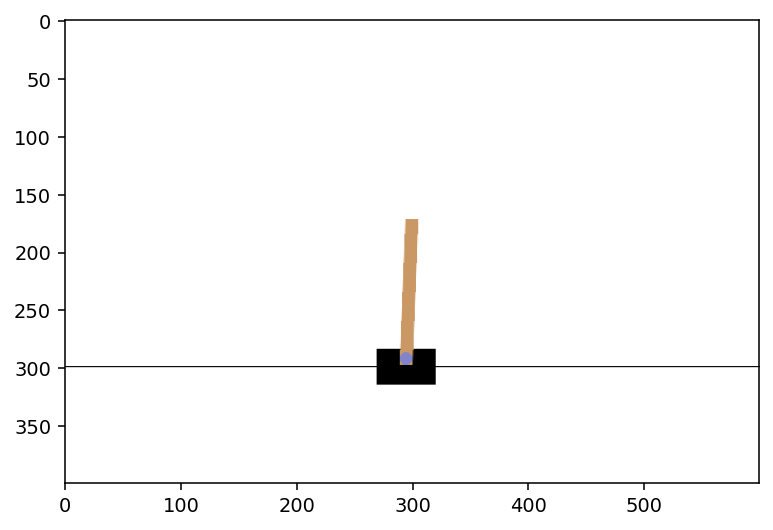

In [10]:
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
# Более высокое качество графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
import gymnasium as gym
# Автоматическая загрузка изменений модулей
%load_ext autoreload
%autoreload 2

from utils import generate_session, train, get_reseted_env

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)


env_name = 'CartPole-v1'
env = get_reseted_env(env_name)

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [6]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

You may also use your favorite neural framework, if it doesn't make it too difficult. The idea is the main thing.

In [2]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, list(range(n_actions)), list(range(n_actions)))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [9]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.0473386  -0.03672018  0.01179173 -0.03462135]
 [-0.04807301  0.1582307   0.0110993  -0.32356066]
 [-0.0449084   0.35319287  0.00462809 -0.61272275]
 [-0.03784454  0.54824984 -0.00762637 -0.90394443]
 [-0.02687954  0.74347425 -0.02570526 -1.1990147 ]]
actions: [1, 1, 1, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.

# Training loop
Generate sessions, select N best and fit to those.

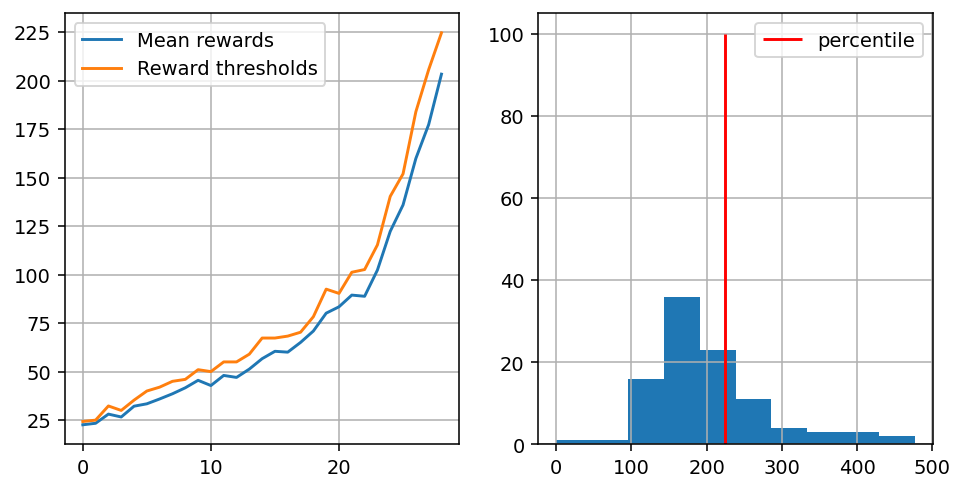

mean reward = 203.290, threshold=224.600
Training time for last epoch: 3.35 seconds

You Win!


In [22]:
epochs = 100
n_sessions = 100
n_sessions_in_epoch = 100
percentile = 70
win_value = 190

set_seed()
train(agent, env_name, epochs, n_sessions_in_epoch, percentile, win_value, reward_min=0)

# Results

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, './videos',  episode_trigger = lambda episode_number: True)

sessions = [generate_session(agent, test=True) for _ in range(5)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v1 and feel stuck, feel free to ask us or your peers for help.

### Tasks (up to 1 point each)

* __2.1__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [23]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

#plt.imshow(visualize_mountain_car(env, agent))

### LunarLander - базовое решение

state vector dim = 8
n_actions = 4


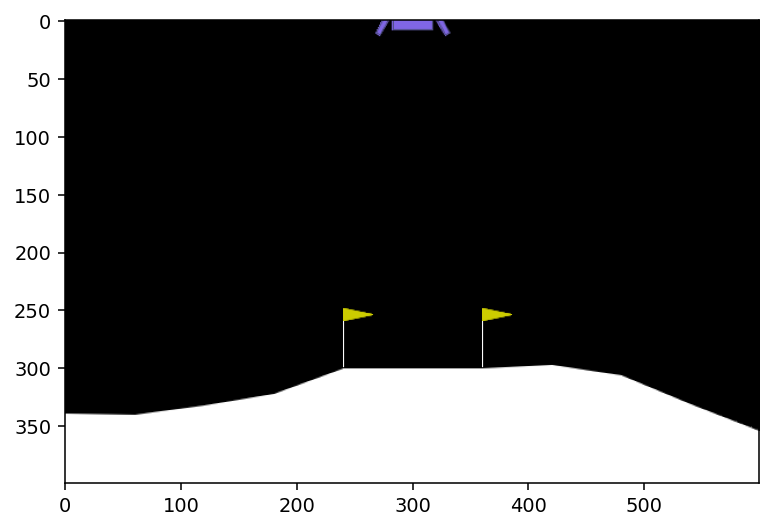

In [12]:
env_name = 'LunarLander-v2'
env = get_reseted_env(env_name)
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [13]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    max_iter=1,  # Default value 200
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, list(range(n_actions)), list(range(n_actions)))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=1)

In [14]:
%time [generate_session(agent, env_name) for _ in range(100)]

CPU times: user 3.46 s, sys: 30.2 ms, total: 3.5 s
Wall time: 3.49 s


[([array([-0.00289164,  1.422076  , -0.29290634,  0.49581987,  0.00335747,
           0.06634773,  0.        ,  0.        ], dtype=float32),
   array([-0.00573597,  1.433532  , -0.28798208,  0.5091442 ,  0.00687489,
           0.0703554 ,  0.        ,  0.        ], dtype=float32),
   array([-0.00862007,  1.4451743 , -0.29179022,  0.51742136,  0.01021633,
           0.06683528,  0.        ,  0.        ], dtype=float32),
   array([-0.01159639,  1.4562136 , -0.30335864,  0.49058154,  0.01587602,
           0.11320426,  0.        ,  0.        ], dtype=float32),
   array([-0.01469908,  1.4679579 , -0.31544405,  0.5219032 ,  0.02099572,
           0.10240333,  0.        ,  0.        ], dtype=float32),
   array([-0.01787224,  1.47965   , -0.32218763,  0.5195753 ,  0.02581602,
           0.0964146 ,  0.        ,  0.        ], dtype=float32),
   array([-0.02112675,  1.4907281 , -0.33239895,  0.49223083,  0.03268605,
           0.13741305,  0.        ,  0.        ], dtype=float32),
   array([-0.

In [15]:
from multiprocessing import cpu_count, Pool

In [22]:
%%time
with Pool(cpu_count()-1) as p:
    p.starmap(generate_session, [(deepcopy(agent), env_name)] * 100)

CPU times: user 87 ms, sys: 124 ms, total: 212 ms
Wall time: 3.68 s


In [47]:
Parallel(n_jobs=5, prefer='threads', verbose=10)(delayed(generate_session)(agent) for _ in range(n_sessions_in_epoch))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    3.2s finished


[([array([-0.00782213,  1.4216521 , -0.79231864,  0.47694317,  0.00907074,
           0.17947195,  0.        ,  0.        ], dtype=float32),
   array([-0.01572723,  1.4318011 , -0.8015641 ,  0.45096695,  0.02000923,
           0.21879002,  0.        ,  0.        ], dtype=float32),
   array([-0.02363272,  1.4413531 , -0.8015982 ,  0.42434517,  0.03094112,
           0.2186578 ,  0.        ,  0.        ], dtype=float32),
   array([-0.03153849,  1.4503064 , -0.80163014,  0.39766678,  0.04187194,
           0.21863654,  0.        ,  0.        ], dtype=float32),
   array([-0.03944473,  1.4586616 , -0.8016618 ,  0.37098932,  0.05280096,
           0.21860066,  0.        ,  0.        ], dtype=float32),
   array([-0.04742155,  1.4664242 , -0.8104946 ,  0.34451386,  0.0654867 ,
           0.2537382 ,  0.        ,  0.        ], dtype=float32),
   array([-0.05537949,  1.4742677 , -0.8088192 ,  0.34797952,  0.07840319,
           0.25835365,  0.        ,  0.        ], dtype=float32),
   array([-0.

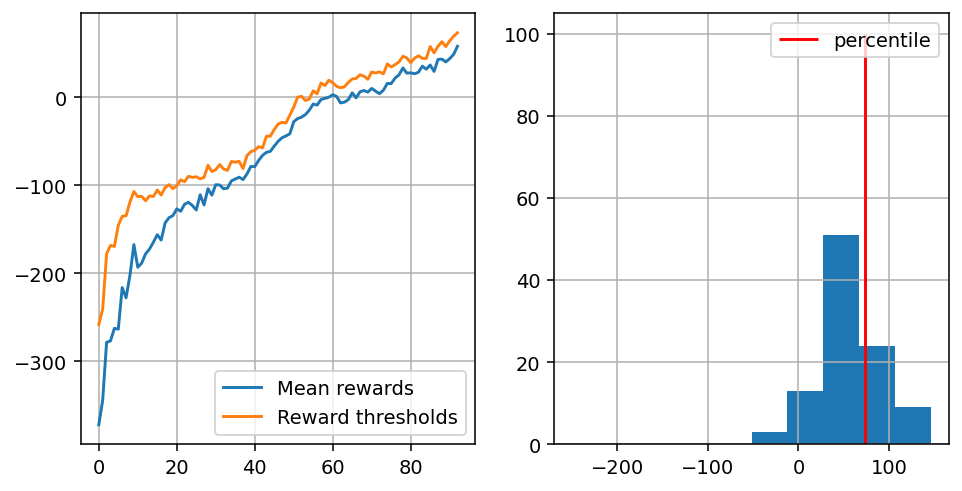

mean reward = 58.222, threshold=73.576
Training time for last epoch: 57.01 seconds

You Win!
CPU times: user 20min 42s, sys: 13.5 s, total: 20min 55s
Wall time: 20min 39s


In [26]:
epochs = 150
n_sessions_in_epoch = 100
percentile = 70
win_value = 50

set_seed()
%time train(agent, epochs, n_sessions_in_epoch, percentile, win_value, reward_min=-250)

### LunarLander - оптимизация

In [11]:
from line_profiler import LineProfiler

def print_profile_func(func, *args, **kwargs):
    lprofiler = LineProfiler()
    lp_wrapper = lprofiler(func)
    lp_wrapper(*args, **kwargs)
    lprofiler.print_stats()

In [28]:
agent = MLPClassifier(
    hidden_layer_sizes=(15, 15),
    activation='relu',
    solver='adam',  # Default adam
    learning_rate_init=0.005,  # Default 0.001
    #learning_rate='adaptive',  # Only with sgd
    max_iter=800,  # Default 200
)
agent.partial_fit([env.reset()[0]] * n_actions, list(range(n_actions)), list(range(n_actions)))

MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate_init=0.005,
              max_iter=800)

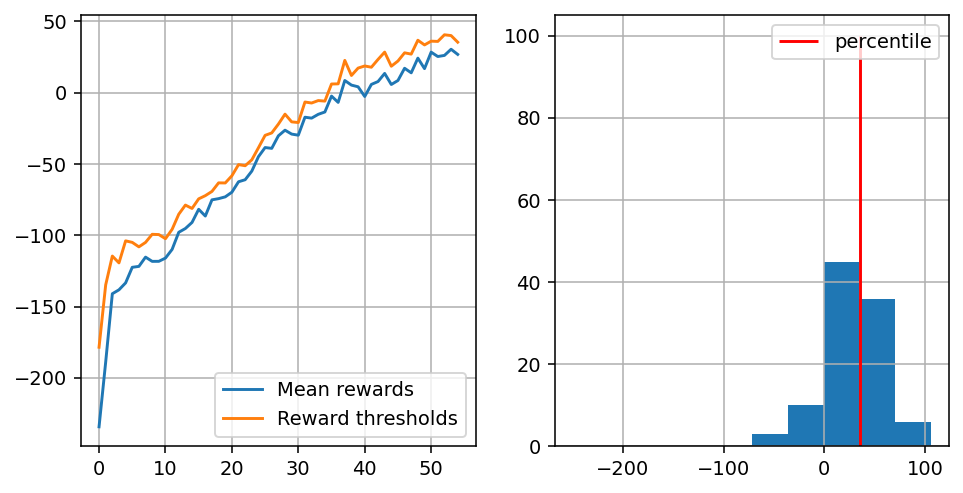

mean reward = 26.834, threshold=35.396
Training time for last epoch: 58.49 seconds



KeyboardInterrupt: 

In [29]:
epochs = 400
n_sessions_in_epoch = 100
percentile = 60
win_value = 50

set_seed()
%time train(agent, epochs, n_sessions_in_epoch, percentile, win_value, reward_min=-250, parallel=True)

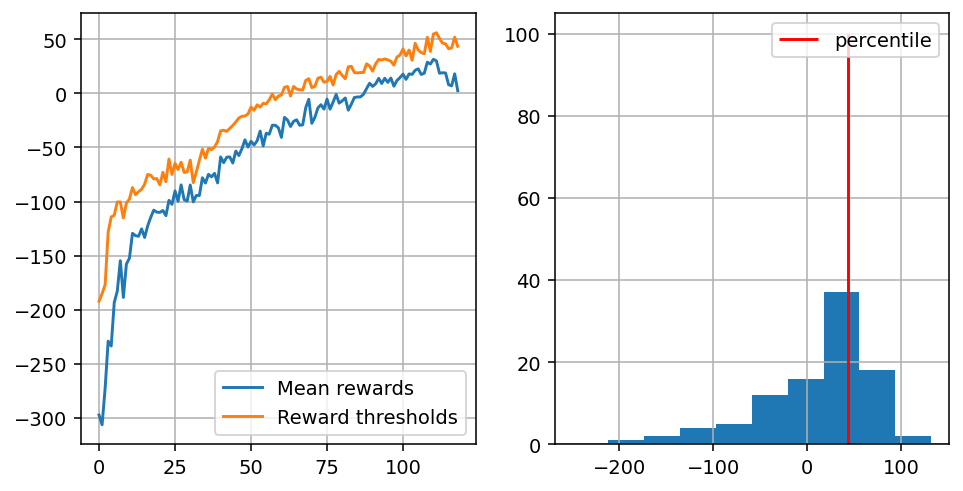

mean reward = 2.419, threshold=43.433
Training time for last epoch: 70.28 seconds


KeyboardInterrupt: 

In [20]:
epochs = 1000
n_sessions_in_epoch = 100
percentile = 90
win_value = 50

%time train(agent, epochs, n_sessions_in_epoch, percentile, win_value, reward_min=-250)

### Bonus tasks (up to 0.5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v1"](https://gymnasium.farama.org/environments/classic_control/pendulum/) __(score -150)__.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) __(score +90)__ or [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) __(score -200)__. Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__